In [1]:
import random

import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax.training.train_state import TrainState
from stable_baselines3.common.buffers import ReplayBuffer

from rlmcmc.env import RLMHEnv
from mcmctoolbox.functoolbox import flat

from tqdm.auto import trange

import toml
from types import SimpleNamespace

import json
import pandas as pd
import bridgestan as bs
from posteriordb import PosteriorDatabase

config = toml.load("./rlmcmc/config/ddpg.toml")
args = SimpleNamespace(**config)

# seeding
random.seed(args.seed)
np.random.seed(args.seed)
key = jax.random.PRNGKey(args.seed)
key, actor_key, qf1_key = jax.random.split(key, 3)

import logging
logging.basicConfig(filename="DDPG_single.log", level=logging.INFO)

CUDA backend failed to initialize: Found cuPTI version 18, but JAX was built against version 20, which is newer. The copy of cuPTI that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
# Initialize Agent

class QNetwork(nn.Module):
    """
    Critic Network
    """
    @nn.compact
    def __call__(self, x: jnp.ndarray, a: jnp.ndarray):
        x = jnp.concatenate([x, a], -1)
        x = nn.Dense(48)(x)
        x = nn.softplus(x)
        x = nn.Dense(48)(x)
        x = nn.softplus(x)
        x = nn.Dense(1)(x)
        x = nn.softplus(x)
        return x

In [3]:
class Actor(nn.Module):
    action_dim: int

    @nn.compact
    def __call__(self, obs: jnp.ndarray):
        """
        Mu function
        """
        x, mcmc_noise = jnp.split(obs, [self.action_dim-1], axis=1)
        x_star = self.gene_x_star(x, mcmc_noise)

        log_q_ratio = self.log_q(
            x, x_star, self.cov(x_star)
        ) - self.log_q(
            x_star, x, self.cov(x)
        )

        return jnp.hstack(
            [x_star, jnp.expand_dims(log_q_ratio, axis=1)]
        )

    def low_rank_vect_and_mag(self, x):
        x = nn.Dense(48)(x)
        x = nn.softplus(x)
        x = nn.Dense(48)(x)
        x = nn.softplus(x)
        x = nn.Dense(self.action_dim)(x)
        x = nn.softplus(x)
        return x

    def log_q(self, x, mean, cov):
        return jax.scipy.stats.multivariate_normal.logpdf(
            x,
            mean=mean,
            cov=cov
        )

    def cov(self, x):
        low_rank_vec, mag = jnp.split(self.low_rank_vect_and_mag(x), [self.action_dim-1], axis=1)
        return jnp.einsum(
            "ij,ik->ijk", low_rank_vec, low_rank_vec
            ) + jnp.einsum("ij,jk->ijk", mag, jnp.eye(self.action_dim-1))

    def gene_x_star(self, x, mcmc_noise):

        logging.info(mcmc_noise)

        return x + jnp.einsum(
            "ij, ijk -> ik", mcmc_noise, jnp.sqrt(self.cov(x))
        )

In [4]:
class TrainState(TrainState):
    target_params: flax.core.FrozenDict

In [5]:
# Load DataBase Locally
pdb_path = "/home/congye/Code/PythonProjects/LearningAdaptiveMCMC/Python/posteriordb/posterior_database"
my_pdb = PosteriorDatabase(pdb_path)

# Load Dataset
posterior = my_pdb.posterior("test-AnnulusGaussianMixture-test-AnnulusGaussianMixture")
stan = posterior.model.stan_code_file_path()
data = json.dumps(posterior.data.values())
model = bs.StanModel.from_stan_file(stan, data)

# Gold Standard
gs = posterior.reference_draws()
df = pd.DataFrame(gs)
gs_chains = np.zeros((sum(flat(posterior.information['dimensions'].values())),\
                       posterior.reference_draws_info()['diagnostics']['ndraws']))
for i in range(len(df.keys())):
    s = []
    for j in range(len(df[df.keys()[i]])):
        s += df[df.keys()[i]][j]
    gs_chains[i, :] = s
linv = np.linalg.inv(np.cov(gs_chains))

# Extract log-P-pdf and its gradient
log_p = model.log_density


In [6]:
# Setup env
sample_dim = 2
action_dim = sample_dim + 1
state_dim = sample_dim * 2

total_timesteps=5_000
args.total_timesteps = total_timesteps
args.batch_size = 48

env = RLMHEnv(
    log_target_pdf=log_p,
    sample_dim=sample_dim,
    total_timesteps=total_timesteps
    )
rb = ReplayBuffer(
    args.buffer_size,
    env.observation_space,
    env.action_space,
    device='cpu',
    handle_timeout_termination=False
)

In [7]:
# Start
obs, _ = env.reset()
actor = Actor(action_dim=sample_dim+1)
qf1 = QNetwork()

In [8]:
actor_state = TrainState.create(
    apply_fn=actor.apply,
    params=actor.init(actor_key, obs),
    target_params=actor.init(actor_key, obs),
    tx=optax.adam(learning_rate=args.learning_rate),
)

qf1_state = TrainState.create(
    apply_fn=qf1.apply,
    params=qf1.init(qf1_key, obs, env.action_space.sample()),
    target_params=qf1.init(qf1_key, obs, env.action_space.sample()),
    tx=optax.adam(learning_rate=args.learning_rate),
)

# actor.apply = jax.jit(actor.apply)
# qf1.apply = jax.jit(qf1.apply)

In [9]:
@jax.jit
def update_critic(
    actor_state: TrainState,
    qf1_state: TrainState,
    observations: np.ndarray,
    actions: np.ndarray,
    next_observations: np.ndarray,
    rewards: np.ndarray,
    dones: np.ndarray,
):
    # next_state_actions = (actor.apply(actor_state.target_params, next_observations)).clip(-1, 1)
    next_state_actions = (actor.apply(actor_state.target_params, next_observations))
    qf1_next_target = qf1.apply(qf1_state.target_params, next_observations, next_state_actions).reshape(-1)
    next_q_value = (rewards + (1 - dones) * args.gamma * (qf1_next_target)).reshape(-1)

    def mse_loss(params):
        qf1_a_values = qf1.apply(params, observations, actions).squeeze()
        return ((qf1_a_values - next_q_value) ** 2).mean(), qf1_a_values.mean()

    (qf1_loss_value, qf1_a_values), grads = jax.value_and_grad(mse_loss, has_aux=True)(qf1_state.params)
    qf1_state = qf1_state.apply_gradients(grads=grads)
    return qf1_state, qf1_loss_value, qf1_a_values

@jax.jit
def update_actor(
    actor_state: TrainState,
    qf1_state: TrainState,
    observations: np.ndarray,
):
    def actor_loss(params):
        return -qf1.apply(qf1_state.params, observations, actor.apply(params, observations)).mean()

    actor_loss_value, grads = jax.value_and_grad(actor_loss)(actor_state.params)
    actor_state = actor_state.apply_gradients(grads=grads)
    actor_state = actor_state.replace(
        target_params=optax.incremental_update(actor_state.params, actor_state.target_params, args.tau)
    )
    qf1_state = qf1_state.replace(
        target_params=optax.incremental_update(qf1_state.params, qf1_state.target_params, args.tau)
    )
    return actor_state, qf1_state, actor_loss_value

In [10]:
for global_step in trange(args.total_timesteps):
    actions = actor.apply(actor_state.params, obs)
    # actions = (actions + np.random.normal(0, args.exploration_noise)).clip(
    #                 env.action_space.low, env.action_space.high
    #             )
    next_obs, rewards, terminateds, truncateds, infos = env.step(np.array(actions, dtype=np.float64))
    real_next_obs = next_obs.copy()
    rb.add(obs, real_next_obs, actions, rewards, terminateds, infos)

    obs = next_obs

    # Training
    if global_step > args.learning_starts:
        data = rb.sample(args.batch_size)
        qf1_state, qf1_loss_value, qf1_a_values = update_critic(
            actor_state=actor_state,
            qf1_state=qf1_state,
            observations=data.observations.reshape(-1, state_dim).numpy(),
            actions=data.actions.numpy(),
            next_observations=data.next_observations.reshape(-1, state_dim).numpy(),
            rewards=data.rewards.flatten().numpy(),
            dones=data.dones.flatten().numpy()
        )
        if global_step % args.policy_frequency == 0:
            actor_state, qf1_state, actor_loss_value = update_actor(
                actor_state=actor_state,
                qf1_state=qf1_state,
                observations=data.observations.reshape(-1, state_dim).numpy(),
            )

  0%|          | 0/5000 [00:00<?, ?it/s]

In [11]:
state_list = np.array([i for i in env.store_state]).reshape(-1, state_dim)
# action_list = np.array([i.squeeze() for i in env.store_action])

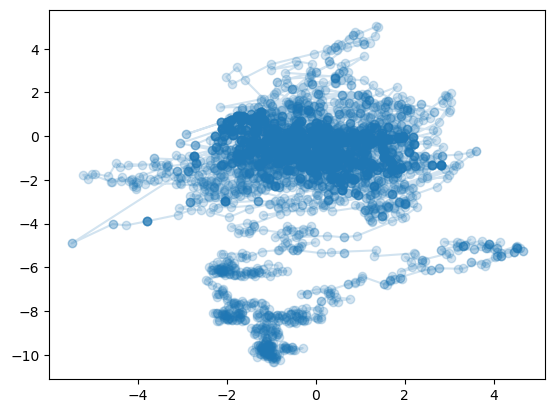

In [12]:
from matplotlib import pyplot as plt


plt.plot(state_list[:, 0], state_list[:, 1], "o-", alpha=0.2)